#### Problem Statement



The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending \(to risky applicants\) at a higher interest rate, etc.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
loan = pd.read_csv("loan.csv")

/tmp/ipykernel_332/3592418794.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan = pd.read_csv("loan.csv")


In [27]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [28]:
loan.shape

(39717, 111)

## Data Cleaning



In [29]:
single_value_columns = loan.columns[loan.nunique() <= 1]

# Dropping all columns which has all duplicate values
loan = loan.drop(columns=single_value_columns)

print(loan.shape)

(39717, 48)


In [30]:
#Removing columns which has more than 10000 null values in it.

#finding total null values in each column and store them in null_value variable.
null_value = loan.isnull().sum()
#printing columns that have more than 0 null values or missing values
null_value[null_value > 0]
loan.drop(null_value[null_value > 10000].index, axis=1, inplace=True)
loan.shape

(39717, 44)

In [31]:
#Removing unnecessary columns
loan.columns
loan.drop(['url', 'title', 'zip_code','member_id'], axis=1, inplace=True)

In [32]:
loan.columns
#From what we've seen, some customer behavior information isn't there when they apply for a loan. This means we can't use those details to predict if they'll be approved for credit. So, we should take those bits out of our data.
loan.drop(['delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc','open_acc', 'pub_rec','revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis=1, inplace=True)
loan.shape

(39717, 20)

In [33]:
loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'addr_state', 'dti', 'pub_rec_bankruptcies'],
      dtype='object')

In [34]:
loan[loan["loan_amnt"] != loan["funded_amnt"]]
#Checked whether we can remove the funded_amnt column since most values are similar. We can't cause a significant number of values differ as well

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,pub_rec_bankruptcies
61,1068934,17500,8950,8925.000000,60 months,17.27%,223.74,D,D3,NaN,6 years,RENT,40000.0,Verified,Dec-11,Fully Paid,small_business,CA,19.47,0.0
66,1069093,12500,8925,8925.000000,60 months,17.27%,223.11,D,D3,grandma kitchen,5 years,RENT,30000.0,Source Verified,Dec-11,Charged Off,debt_consolidation,MN,13.16,1.0
70,1069043,20975,13575,13550.000000,60 months,17.58%,341.63,D,D4,Dollar Tree Stores,5 years,MORTGAGE,44000.0,Verified,Dec-11,Fully Paid,credit_card,GA,18.79,1.0
77,1068416,7250,7200,7175.000000,60 months,21.67%,197.51,F,F3,Cross Country Travel Corp,< 1 year,RENT,75000.0,Verified,Dec-11,Fully Paid,debt_consolidation,CA,24.82,1.0
80,1068994,35000,22075,22050.000000,60 months,17.27%,551.84,D,D3,tutor Per ini Corporation,3 years,MORTGAGE,150000.0,Verified,Dec-11,Fully Paid,home_improvement,NY,7.51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39533,167645,10000,6000,700.000000,36 months,8.70%,189.97,B,B1,Lowe's Distribution Center,3 years,RENT,24000.0,Not Verified,Dec-07,Fully Paid,debt_consolidation,WY,19.45,NaN
39593,141774,20000,4800,1949.999594,36 months,13.12%,162.01,D,D5,Legal Services of New Jersey,8 years,MORTGAGE,85000.0,Not Verified,Oct-07,Charged Off,debt_consolidation,NJ,16.87,NaN
39600,140036,4000,1000,550.000000,36 months,9.96%,32.25,B,B5,Schering-Plough Corp.,1 year,RENT,35000.0,Not Verified,Oct-07,Charged Off,other,NJ,5.83,NaN
39601,139980,12000,5000,1399.996684,36 months,10.91%,163.49,C,C3,Staples,1 year,MORTGAGE,39000.0,Not Verified,Oct-07,Charged Off,other,GA,11.78,NaN


In [38]:
# Re-formating columns

# remove months from term 
loan["term"]  = loan["term"].str.replace(' months', '')
loan['int_rate'] = loan['int_rate'].str.replace('%', '')
loan['emp_length'] = loan['emp_length'].str.replace(r'\D', '', regex=True)
loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,pub_rec_bankruptcies
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,NaN,10,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,AZ,27.65,0.0
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,Ryder,1,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,GA,1.00,0.0
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,IL,8.72,0.0
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,CA,20.00,0.0
4,1075358,3000,3000,3000.0,60,12.69,67.79,B,B5,University Medical Group,1,RENT,80000.0,Source Verified,Dec-11,Current,other,OR,17.94,0.0


In [39]:
loan.shape

(39717, 20)

In [41]:
loan["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

Based on the information above, we see there are three different values, but the "Current" loan status doesn't provide any useful information for deciding whether to approve or reject a loan application. As a result, we should remove the rows with the "Current" value.


In [ ]:
# Checking for missing values across the dataframe
print(loan_data.isnull().sum().sort_values(ascending=False))

emp\_length & pub\_rec\_bankruptcies have null values so fixing those below


In [42]:
loan = loan[loan["loan_status"] != 'Current']
loan.shape

In [44]:
# Removing null valued emp_length , since this can't be fixed
loan_data = loan_data.dropna(subset=['emp_length'])

In [45]:
loan.shape

(38577, 20)

In [46]:
loan.pub_rec_bankruptcies.fillna(0,inplace=True)
loan.shape

(38577, 20)

Deriving new column from given data 


In [48]:
loan['approved_loan_amnt_ratio'] = round(loan.funded_amnt_inv*100/loan.loan_amnt,2)

Checking Outliers and removing them


In [49]:
import plotly.express as px #plotting
px.box(loan_data,x='annual_inc',width=750,height=350,title='Distribution of Annual Income of the Burrower',labels={'annual_inc':'Annual Income'}).show()


In [50]:
## Removing outliers in annual_inc greater than 99th percentile
loan = loan[loan.annual_inc<=np.percentile(loan.annual_inc,99)]

In [51]:
px.box(loan_data,x='loan_amnt',width=750,height=350,title='Distribution of Loan Amount',labels={'loan_amnt':'Loan Amount'}).show()


Upper fence turns out to be 29.175k =29175 whereas max is 35k=35000 which is not much more then upper fence thus will not have much impact on the analysis.


##### Univariate analysis



<AxesSubplot: xlabel='loan_status', ylabel='count'>

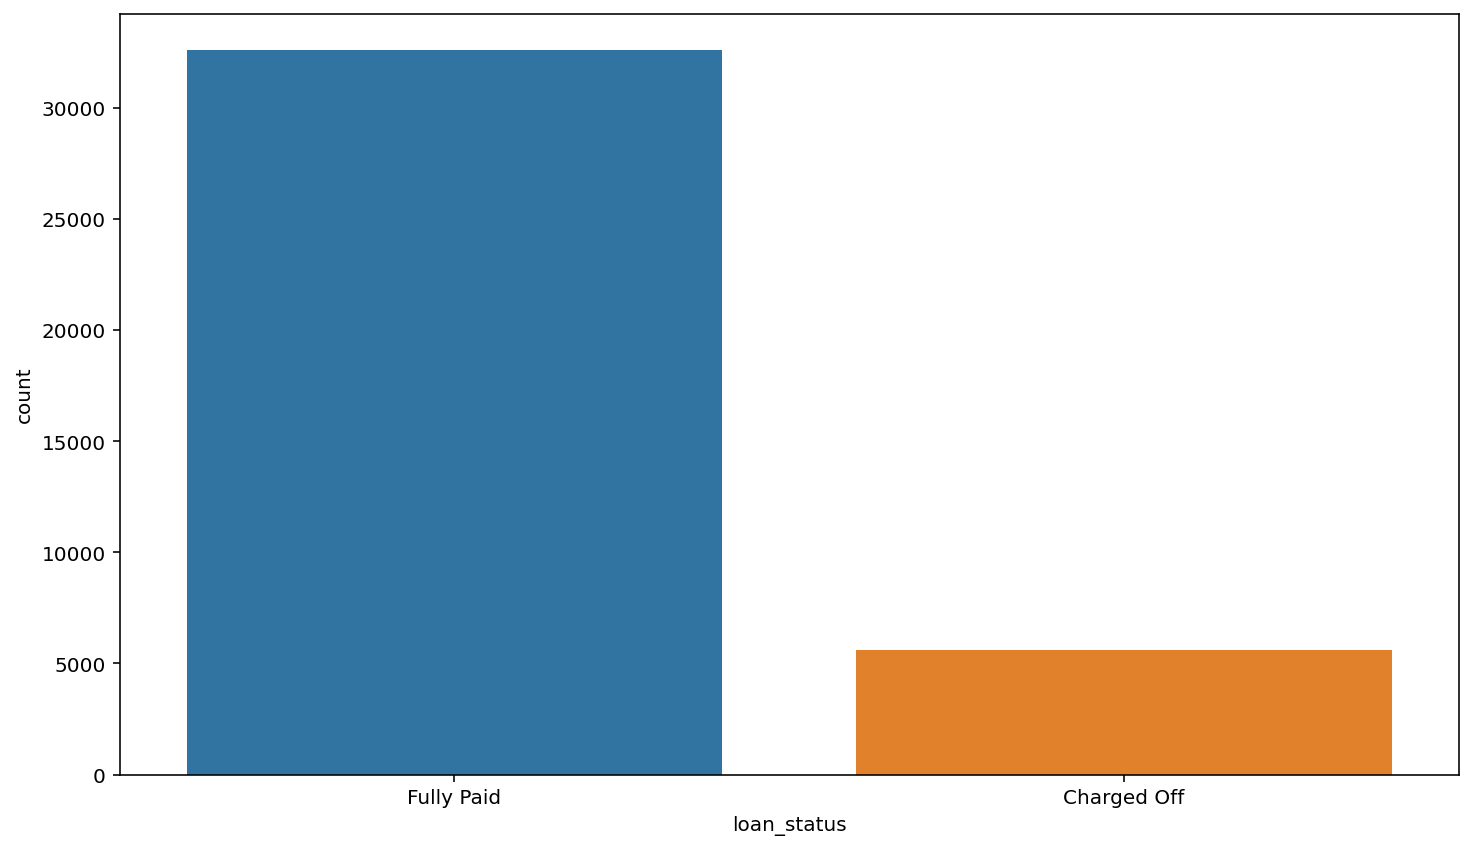

In [53]:
import seaborn as sns
sns.countplot(x = 'loan_status', data = loan)


**Conclusion:** The number of defaulted loans is considerably lower when compared to those that have been fully paid.


In [55]:
print(loan.loan_amnt.describe())
#Plotting histogram of loan amount
px.box(loan,x='loan_amnt',width=750,height=350,title='Distribution of Loan Amount',labels={'loan_amnt':'Loan Amount'}).show()

count    38191.000000
mean     10962.265979
std       7266.157660
min        500.000000
25%       5200.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


**Conclusion** : The loan amount ranges between 500 and 35000, with an average of 9800.


/tmp/ipykernel_332/1754700196.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




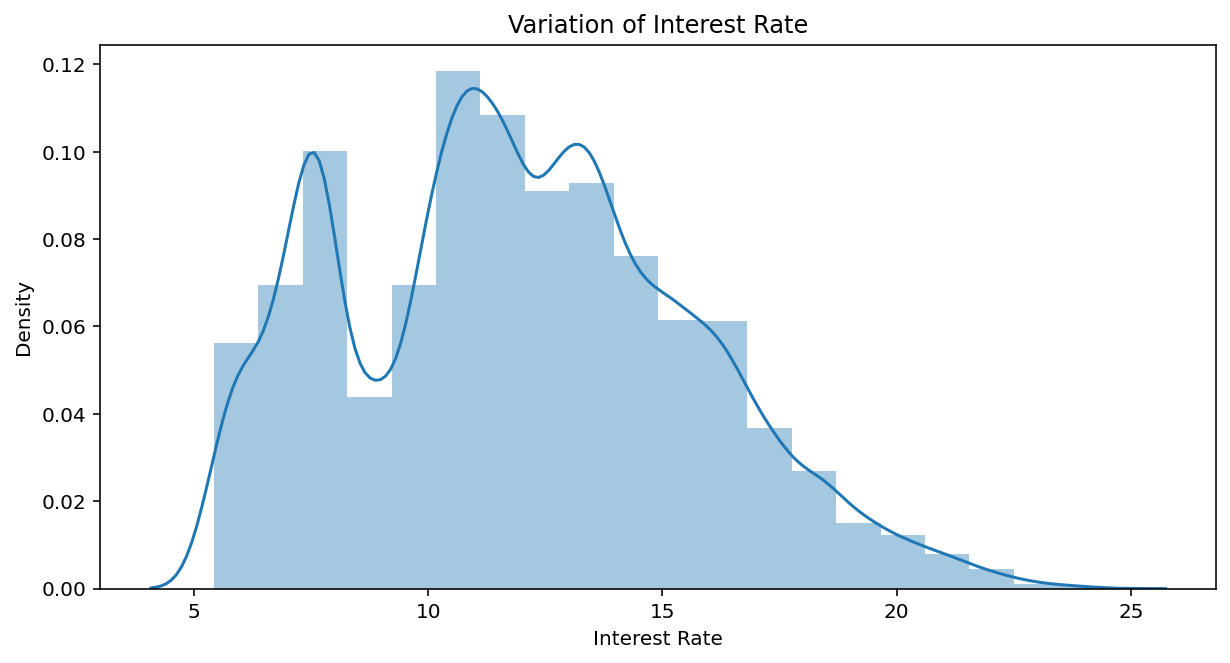

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.distplot(sorted(loan.int_rate),kde=True,bins=20)
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.title('Variation of Interest Rate')
plt.show()

**Conclusion** : The interest rate shows more concentration within the ranges of 5\-10 and 10\-15, with a dip occurring around 10.


/tmp/ipykernel_332/1621750372.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




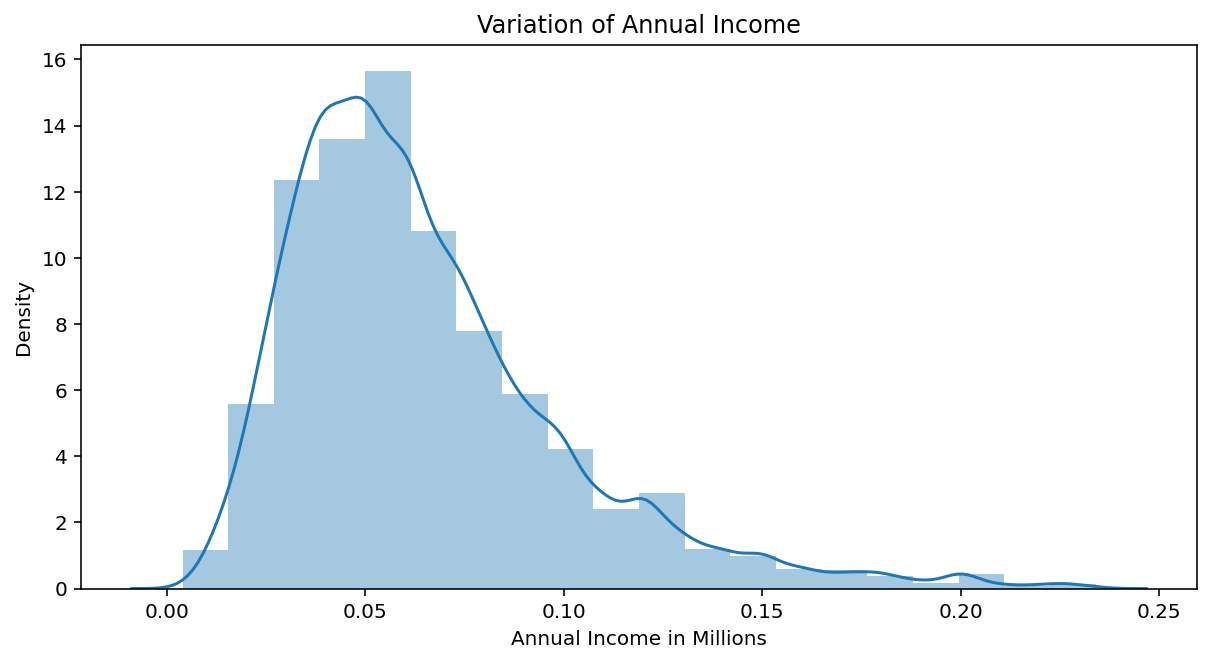

In [60]:
plt.figure(figsize=(10,5))
sns.distplot(loan.annual_inc/1000000,kde=True,bins=20)
plt.xlabel('Annual Income in Millions')
plt.ylabel('Density')
plt.title('Variation of Annual Income',fontsize=12)
plt.show()


**Conclusion** : The annual income exhibits a left\-skewed normal distribution, indicating that the majority of borrowers possess notably lower annual income in comparison to the remaining population.


##### Segmented Univariate Analysis



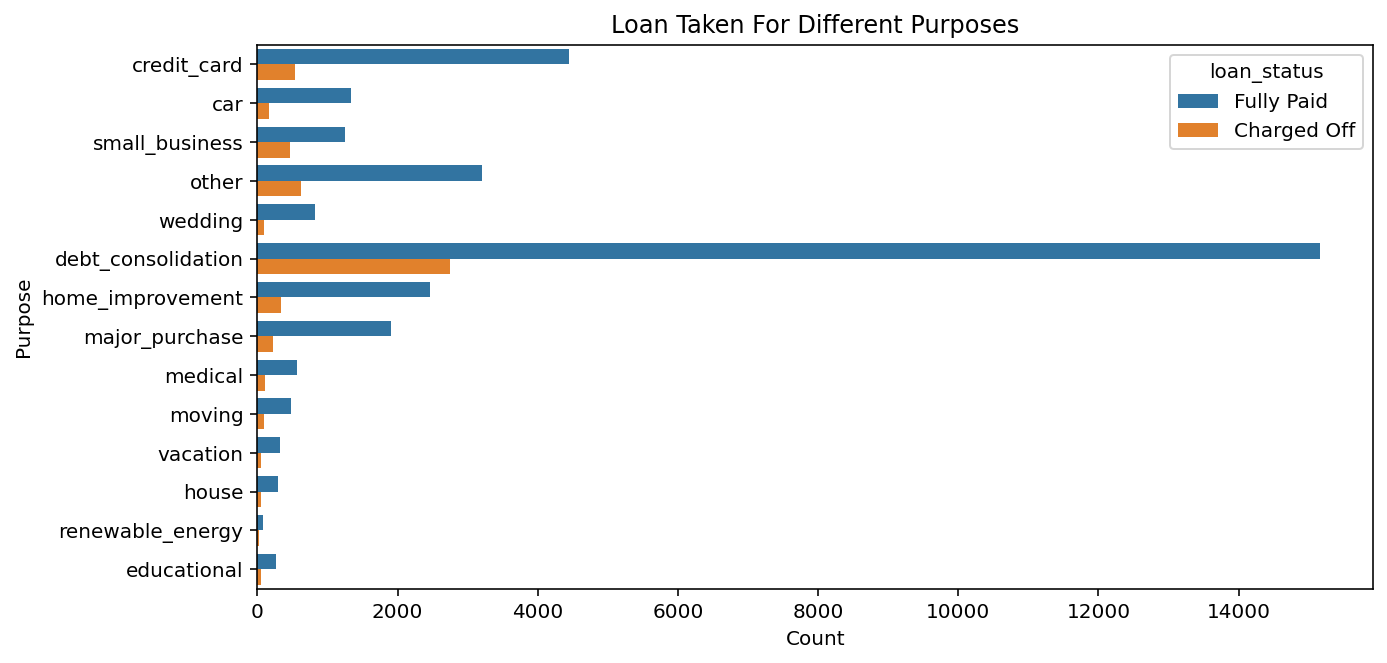

In [63]:
plt.figure(figsize=(10,5))
sns.countplot(data=loan,y='purpose',hue='loan_status')
plt.xlabel('Count')
plt.ylabel('Purpose')
plt.title('Loan Taken For Different Purposes',fontsize=12)
plt.show()

**Conclusion**: Debt Consolidation stands as the most prevalent loan purpose, boasting the highest count of both fully paid and defaulted loans.


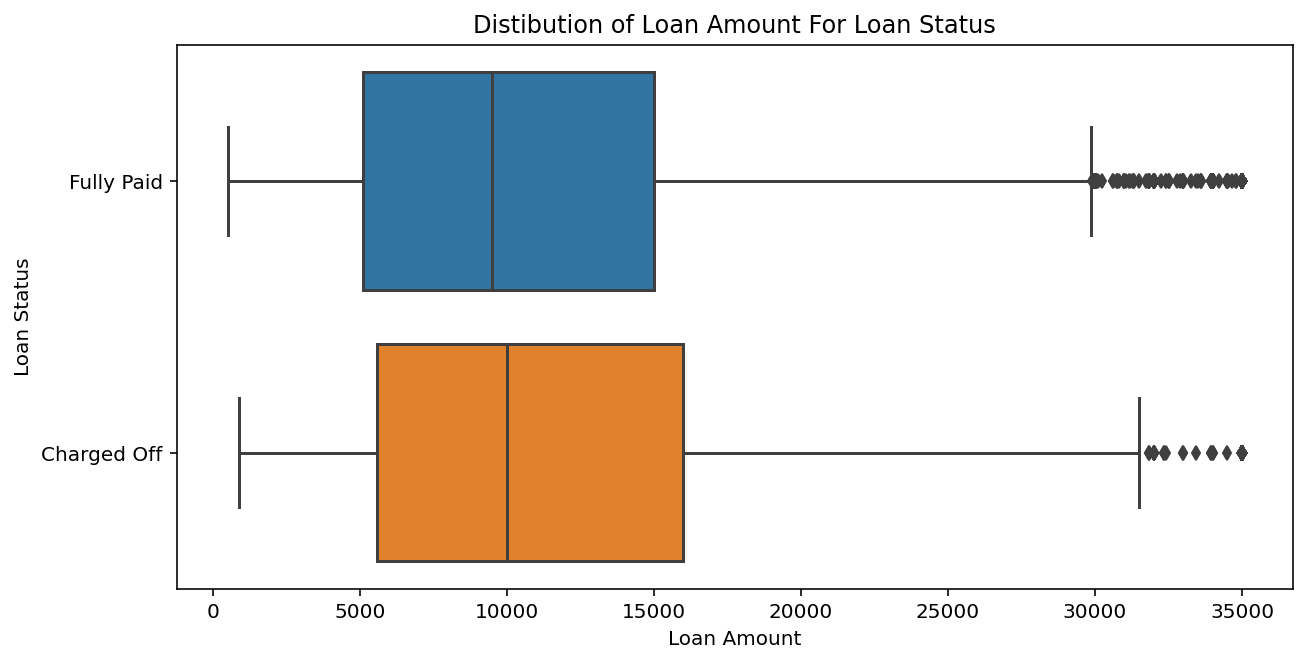

In [64]:
# Distribution of loan_amnt based on loan_status
plt.figure(figsize=(10,5))
sns.boxplot(data=loan,x='loan_amnt',y='loan_status')
plt.xlabel('Loan Amount')
plt.ylabel('Loan Status')
plt.title('Distibution of Loan Amount For Loan Status',fontsize=12)
plt.show()

**Conclusion**: The mean and 25th percentile are identical for both, yet there's a notable increase in the 75th percentile for defaulted loans, suggesting that larger loan amounts have an elevated likelihood of default.


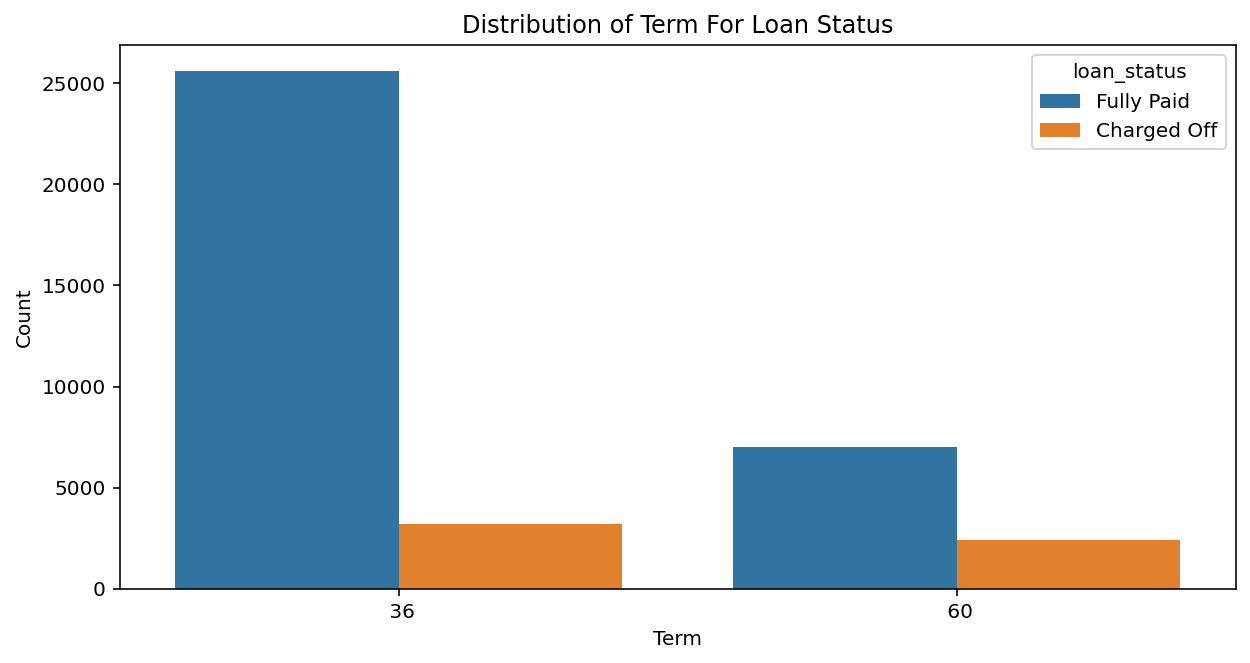

In [66]:
# Distribution of Term based on loan_status
plt.figure(figsize=(10,5))
sns.countplot(data=loan,x='term',hue='loan_status')
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Distribution of Term For Loan Status',fontsize=12)
plt.show()

**Conclusion**: The probability of defaulting is greater for the 60\-month term compared to the 36\-month term, while the 36\-month term exhibits a higher likelihood of loans being fully paid.


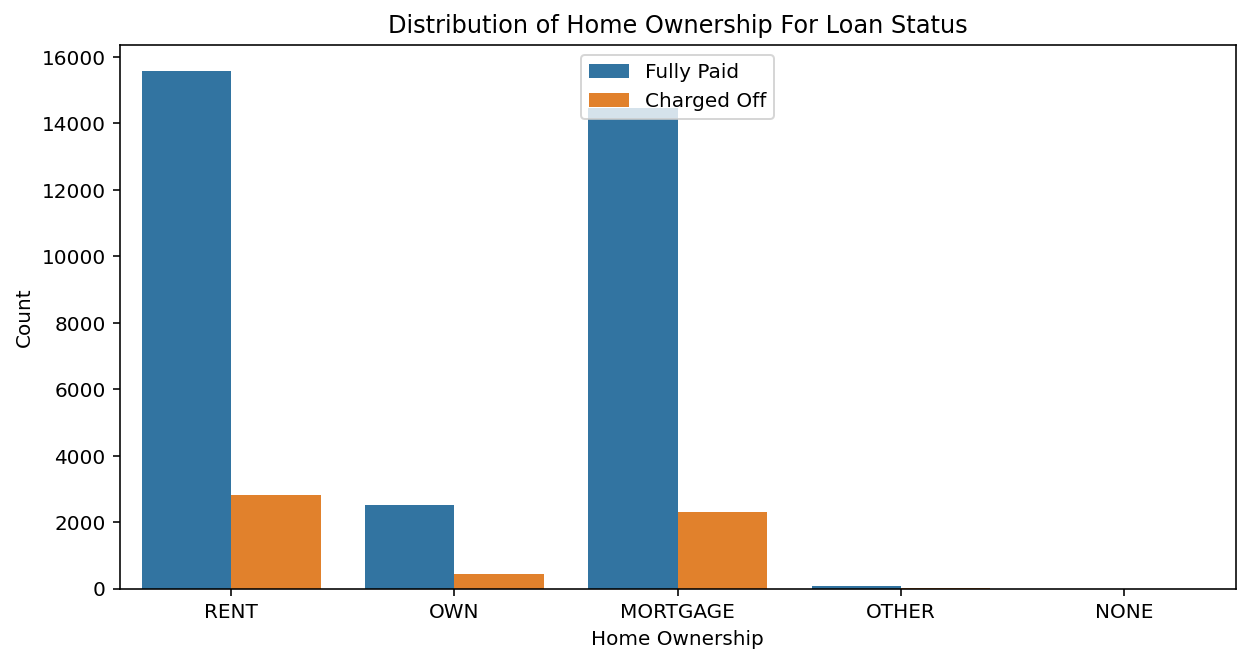

In [68]:
# Distribution of house_ownership based on loan_status
plt.figure(figsize=(10,5))
sns.countplot(data=loan,x='home_ownership',hue='loan_status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Distribution of Home Ownership For Loan Status',fontsize=12)
plt.legend(loc='upper center')
plt.show()

**Conclusion**: Borrowers who own their property experience fewer defaulted loans in comparison to those who are on a mortgage or renting.


##### Bivariate Analysis



<Figure size 720x360 with 0 Axes>

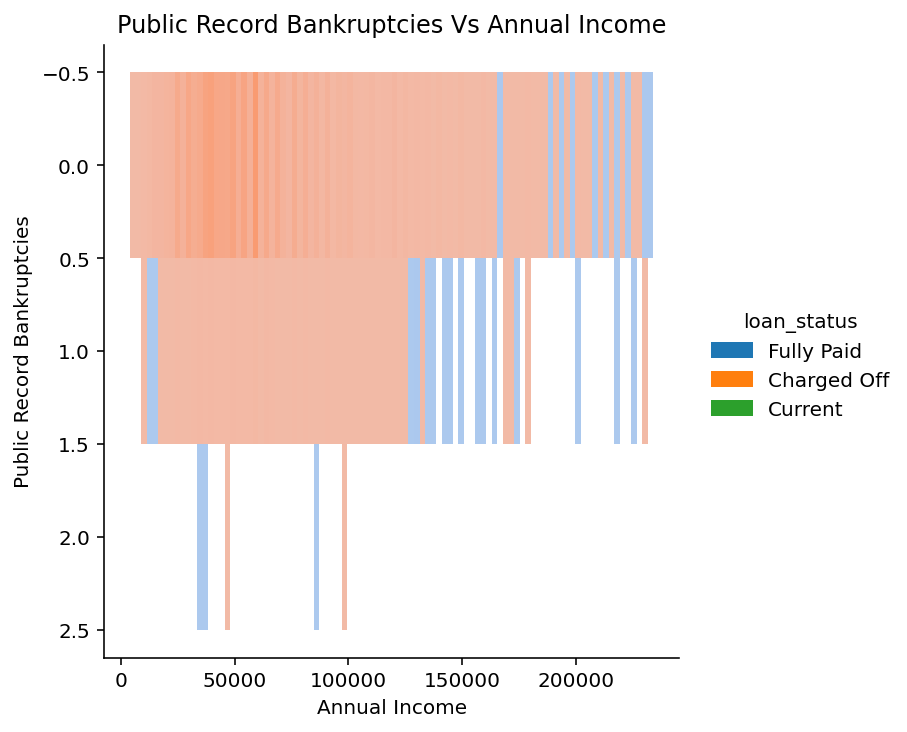

In [70]:
# annual income to public record bankruptcy over loan status
plt.figure(figsize=(10,5))
sns.displot(y=loan_data.pub_rec_bankruptcies.astype('category'),x=loan.annual_inc,hue=loan_data.loan_status)
plt.xlabel('Annual Income')
plt.ylabel('Public Record Bankruptcies')
plt.title('Public Record Bankruptcies Vs Annual Income',fontsize=12)
plt.show()

**Conclusion**: The majority of borrowers have no history of Public Recorded Bankruptcy, making them a secure option for loan issuance.


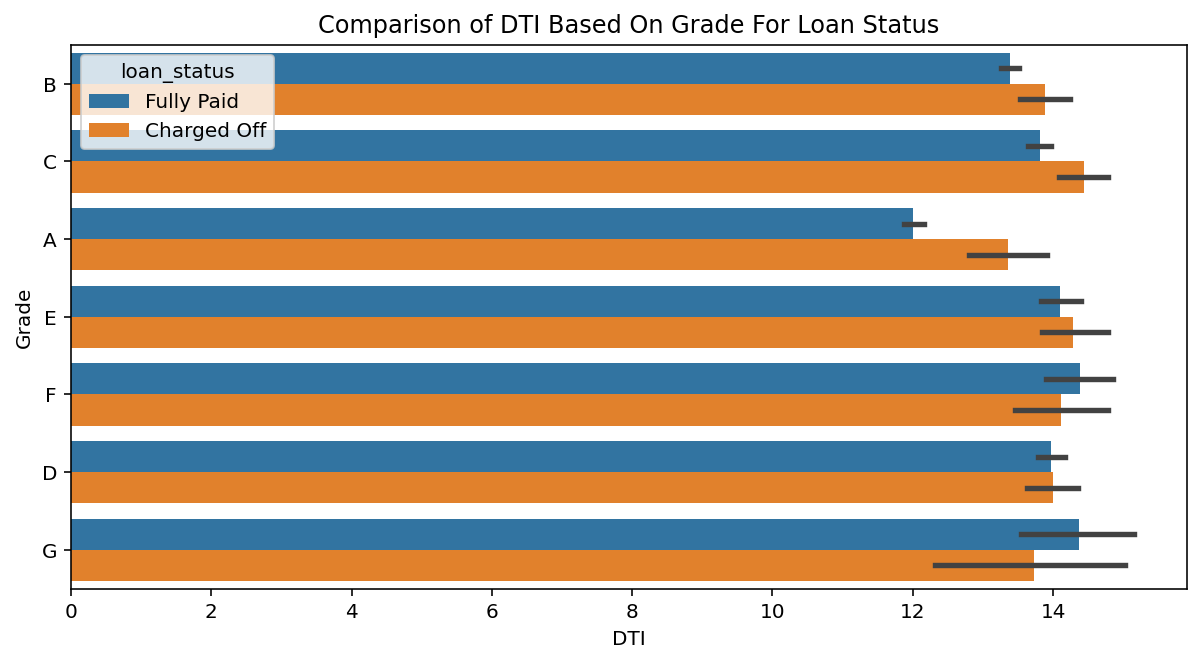

In [74]:
# Comparison of DTI over grade for loan status
plt.figure(figsize=(10,5))
sns.barplot(data=loan,x='dti',y='grade',hue='loan_status')
plt.xlabel('DTI')
plt.ylabel('Grade')
plt.title('Comparison of DTI Based On Grade For Loan Status',fontsize=12)
plt.show()

**Conclusion**: Grade A, representing the lowest risk, exhibits the lowest Debt\-to\-Income \(DTI\) ratio, suggesting a correlation where higher grades correspond to lower default rates.


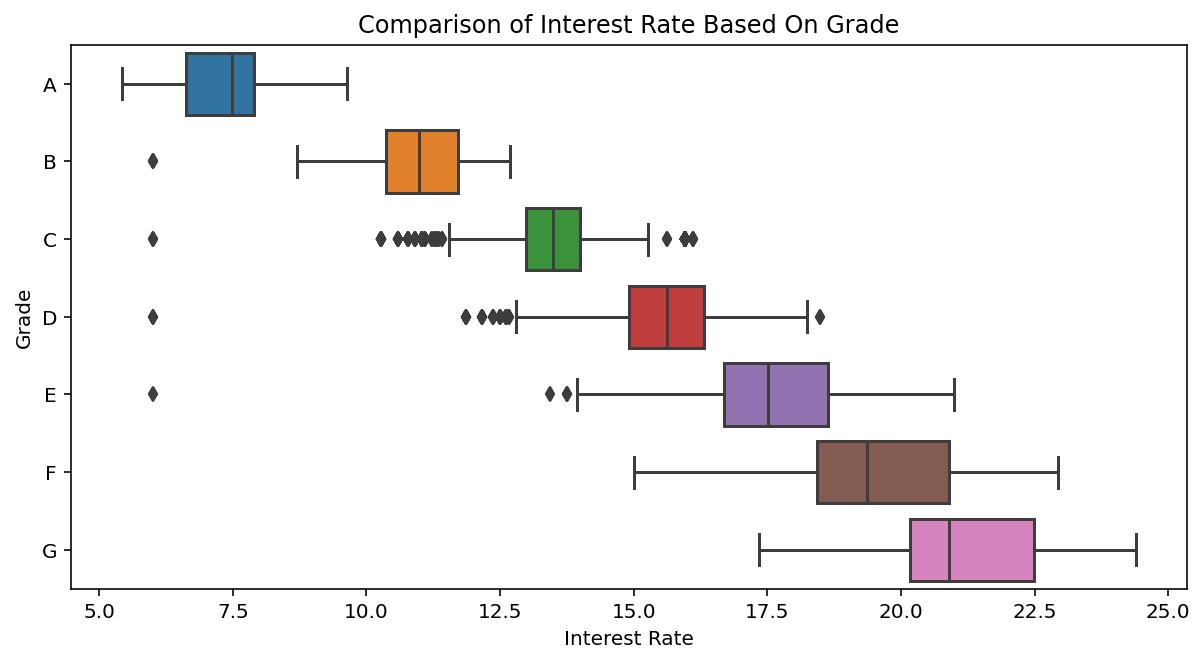

In [77]:
# Comparison of interest rate based on grade
loan.int_rate=loan.int_rate.apply(lambda x:str(x).replace('%','')).astype('float').round(2)
loan.grade=loan.grade.astype('category')
plt.figure(figsize=(10,5))
sns.boxplot(data=loan,x='int_rate',y='grade')
plt.xlabel('Interest Rate')
plt.ylabel('Grade')
plt.title('Comparison of Interest Rate Based On Grade',fontsize=12)
plt.show()

**Conclusion**: The grade serves as an indicator of risk, implying that the interest rate rises in tandem with the level of risk.


<Figure size 864x504 with 0 Axes>

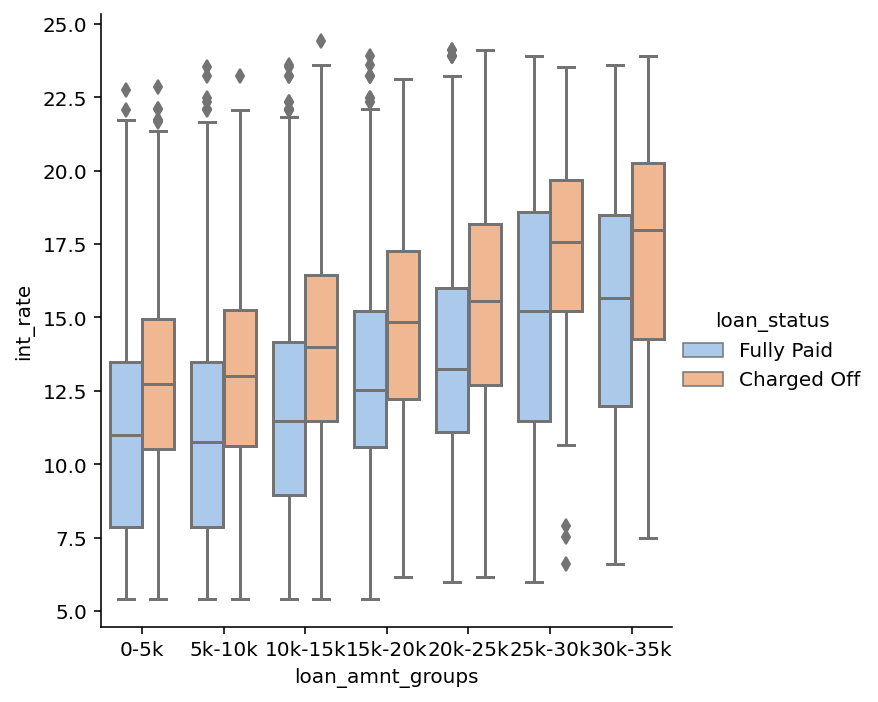

In [80]:
loan['loan_amnt_groups'] = pd.cut(loan['loan_amnt'], bins=7,precision =0,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
plt.tight_layout()
sns.catplot(data =loan,y ='int_rate', x ='loan_amnt_groups', hue ='loan_status',palette="pastel",kind = 'box')

**Conclusion**: The interest rate for charged off loans is pretty high than that of fully paid loans in all the loan\_amount groups.
